# Cisco - Ariel University API Security Detection Challenge 2023
## Attack type 3 code


### Imports and global settings

In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter


# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

dataset_number = 3
test_type = 'attack_type'

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./datasets/dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,request.Attack_Tag,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,RCE,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,NaN,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,NaN,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,NaN,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,NaN,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN


### Basic dataset label arrangements

In [2]:
from urllib.parse import urlparse

# Extracts the path up until the endpoint from the url
def url_path_mid(row):
    parsed = urlparse(row["request.url"])
    return parsed.path[:-1]

# Extracts the path endpoint from the url
def url_path_end(row):
    parsed = urlparse(row["request.url"])
    return parsed.path[-1]

# Extracts the queries from the url
def url_query(row):
    parsed = urlparse(row["request.url"])
    return parsed.query

# Extracts the length of the url
def url_len(row):
    return len(row["request.url"])

# Checks if any of the suspected headers contains a dollar sign
def has_dollarsign(row):
    if "$" in str(row["request.headers.Accept-Encoding"]):
        return True
    elif "$" in str(row["request.headers.Sec-Fetch-Site"]):
        return True
    elif "$" in str(row["request.headers.Sec-Fetch-Dest"]):
        return True
    elif "$" in str(row["request.headers.Set-Cookie"]):
        return True
    return False

# Checks if the url path contains a double dot symbolized by ".."
def has_double_dot(row):
    if ".." in row["url_path_mid"]:
        return True
    elif ".." in row["url_path_end"]:
        return True
    return False

# Checks if the url path contains a double underscore symbolized by "__"
def has_double_underscore(row):
    if "__" in row["url_path_mid"]:
        return True
    if "__" in row["url_path_end"]:
        return True
    return False
    
# Main SQL keywords to look for in the url query
keywords = ["SELECT", "FROM", "or"]

# Checks if the url query contains any of the main SQL keywords
def has_sql_keywords(row):
    for kw in keywords:
        if kw == "SELECT" and f"{kw}%20" in row["url_query"]:
            return True
        elif f"%20{kw}%20" in row["url_query"]:
            return True
    return False

# Checks if the url contains the word "forum"
def has_forum(row):
    if "forum" in row["url_path_mid"]:
        return True
    if "forum" in row["url_path_end"]:
        return True
    return False

# Checks if the url contains the new line character "%0A"
def has_new_line(row):
    if "%0A" in row["url_query"]:
        return True
    return False

In [3]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# make new columns for the features
df['url_length'] = df.apply(lambda row: url_len(row), axis=1)
df["url_path_mid"] = df.apply(lambda row: url_path_mid(row), axis=1)
df["url_path_end"] = df.apply(lambda row: url_path_end(row), axis=1)
df["url_query"] = df.apply(lambda row: url_query(row), axis=1)
df["has_dollarsign"] = df.apply(lambda row: has_dollarsign(row), axis=1)
df["has_doubledot"] = df.apply(lambda row: has_double_dot(row), axis=1)
df["has_doubleUnderScore"] = df.apply(lambda row: has_double_underscore(row), axis=1)
df["has_sql_keyword"] = df.apply(lambda row: has_sql_keywords(row), axis=1)
df["has_forum"] = df.apply(lambda row: has_forum(row), axis=1)
df["has_new_line"] = df.apply(lambda row: has_new_line(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)
df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label,url_length,url_path_mid,url_path_end,url_query,has_dollarsign,has_doubledot,has_doubleUnderScore,has_sql_keyword,has_forum,has_new_line
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,RCE,Malware,109,/greet/%7B%7Bget_flashed_messages.__globals__....,D,,False,False,True,False,False,False
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,Benign,Benign,127,/about/gree,t,id=8730419.269779723&resource_id=2wI0Z0uehihwD...,False,False,False,False,False,False
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",NaN,NaN,NaN,NaN,Benign,Benign,104,/static/download_txt/Inez.txtfilename%3D0MGnu5...,Y,,False,False,False,False,False,False
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,Benign,Benign,111,/categories/check/al,l,resource=I5VeE2hcp0kx726mh6LmxWSLwnhwOGTYeMOB3...,False,False,False,False,False,False
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,Benign,Benign,61,/orders/get/id/458,1,id=6201978.255995754,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144495,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=CUsow_eOa54yp9oNsd1BhZF2lKtgt-PGMG7iBnLba...,"Thu, 15 Dec 2022 00:49:47 GMT",GET,http://127.0.0.1:5000/?res_id=kc66M-9P2z2nOc6C...,,200 OK,text/html; charset=utf-8,34,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,Benign,Benign,73,,/,res_id=kc66M-9P2z2nOc6C-bceW_F-hES5FYyxZAExSrv...,False,False,False,False,False,False
144496,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GET,http://127.0.0.1:5000/bookstore,,200 OK,application/json,41,200,"{""message"": ""Welcome to the Book Store!""}

In [4]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    df[column] = df[column].fillna('None')
    
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label,url_length,url_path_mid,url_path_end,url_query,has_dollarsign,has_doubledot,has_doubleUnderScore,has_sql_keyword,has_forum,has_new_line
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,None,None,None,None,RCE,Malware,109,/greet/%7B%7Bget_flashed_messages.__globals__....,D,,False,False,True,False,False,False
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,None,None,None,None,Benign,Benign,127,/about/gree,t,id=8730419.269779723&resource_id=2wI0Z0uehihwD...,False,False,False,False,False,False
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",None,None,None,None,Benign,Benign,104,/static/download_txt/Inez.txtfilename%3D0MGnu5...,Y,,False,False,False,False,False,False
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",None,None,None,None,Benign,Benign,111,/categories/check/al,l,resource=I5VeE2hcp0kx726mh6LmxWSLwnhwOGTYeMOB3...,False,False,False,False,False,False
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",None,None,None,None,Benign,Benign,61,/orders/get/id/458,1,id=6201978.255995754,False,False,False,False,False,False


In [5]:
# This is a list of the headers that we want to remove from our model
COLUMNS_TO_REMOVE = ['response.headers.Content-Length',
                    'request.headers.Date', 
                    "request.headers.Sec-Fetch-Dest", 
                    "request.headers.Connection", 
                    "request.headers.Accept", 
                    "request.headers.Sec-Fetch-User",
                    "request.headers.Host",
                    "response.headers.Set-Cookie", 
                    "response.status",
                    "request.url"]

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()

    # Run LabelEncoder on the chosen features
    for column in df.columns.to_list(): 
        df[column] = le.fit_transform(df[column])
    
    # # Remove some columns that may be needed for the model
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)
df.head()

,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Set-Cookie,request.method,request.body,response.headers.Content-Type,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,attack_type,label,url_length,url_path_mid,url_path_end,url_query,has_dollarsign,has_doubledot,has_doubleUnderScore,has_sql_keyword,has_forum,has_new_line
0,6,1,2,1,1,118596,0,0,1,0,246,14,2,0,5,1,77,23,15,0,0,0,1,0,0,0
1,24,1,3,1,1,25005,0,0,1,0,246,14,2,0,0,0,95,1,53,31918,0,0,0,0,0,0
2,30,1,4,1,2,69286,0,0,0,0,2934,14,2,0,0,0,72,8952,32,0,0,0,0,0,0,0
3,28,1,4,1,2,8697,0,0,0,0,0,14,2,0,0,0,79,7,45,43239,0,0,0,0,0,0
4,22,1,1,1,2,33091,0,0,0,5,5865,14,2,0,0,0,29,5764,4,23763,0,0,0,0,0,0


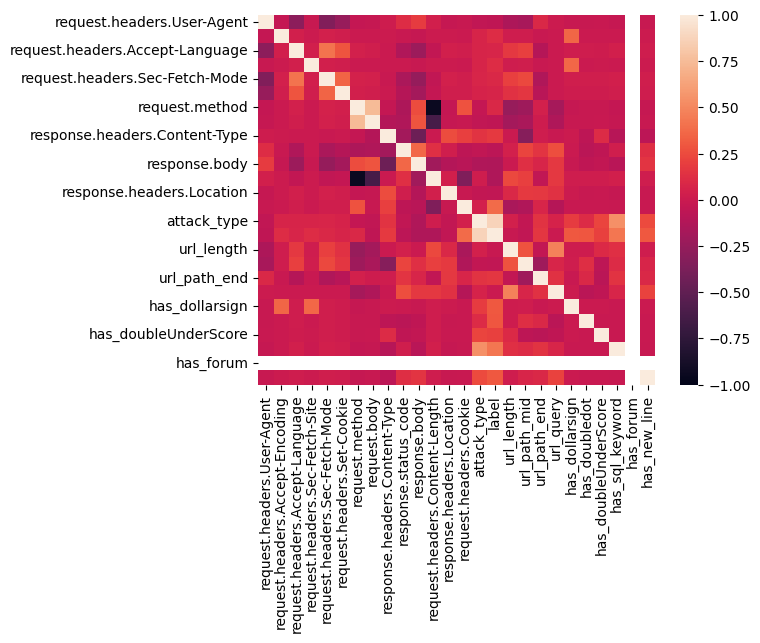

In [6]:
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=False)

In [7]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144500 entries, 0 to 144499
Data columns (total 26 columns):
 #   Column                           Non-Null Count   Dtype
---  ------                           --------------   -----
 0   request.headers.User-Agent       144500 non-null  int64
 1   request.headers.Accept-Encoding  144500 non-null  int64
 2   request.headers.Accept-Language  144500 non-null  int64
 3   request.headers.Sec-Fetch-Site   144500 non-null  int64
 4   request.headers.Sec-Fetch-Mode   144500 non-null  int64
 5   request.headers.Set-Cookie       144500 non-null  int64
 6   request.method                   144500 non-null  int64
 7   request.body                     144500 non-null  int64
 8   response.headers.Content-Type    144500 non-null  int64
 9   response.status_code             144500 non-null  int64
 10  response.body                    144500 non-null  int64
 11  request.headers.Content-Length   144500 non-null  int64
 12  response.headers.Location     

In [8]:
# Choose the right features
# In our example code we choose all the columns as our feature

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Set-Cookie', 'request.method', 'request.body', 'response.headers.Content-Type', 'response.status_code', 'response.body', 'request.headers.Content-Length', 'response.headers.Location', 'request.headers.Cookie', 'url_length', 'url_path_mid', 'url_path_end', 'url_query', 'has_dollarsign', 'has_doubledot', 'has_doubleUnderScore', 'has_sql_keyword', 'has_forum', 'has_new_line']


request.headers.User-Agent         int64
request.headers.Accept-Encoding    int64
request.headers.Accept-Language    int64
request.headers.Sec-Fetch-Site     int64
request.headers.Sec-Fetch-Mode     int64
request.headers.Set-Cookie         int64
request.method                     int64
request.body                       int64
response.headers.Content-Type      int64
response.status_code               int64
response.body                      int64
request.headers.Content-Length     int64
response.headers.Location          int64
request.headers.Cookie             int64
attack_type                        int64
label                              int64
url_length                         int64
url_path_mid                       int64
url_path_end                       int64
url_query                          int64
has_dollarsign                     int64
has_doubledot                      int64
has_doubleUnderScore               int64
has_sql_keyword                    int64
has_forum       

## Train test split

In [9]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing RandomForest model
# X_Train and y_Train will be used for training
# X_test and y_test will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(118995, 24) (118995,)
(25505, 24) (25505,)


Counter({5: 1612,
         0: 128420,
         6: 3173,
         1: 3257,
         7: 3290,
         3: 1578,
         4: 1626,
         2: 1544})

## Model choosing and fitting

In [10]:
# We train the model on the training data
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))


[(0, 105753), (1, 2682), (2, 1272), (3, 1300), (4, 1339), (5, 1327), (6, 2613), (7, 2709)]


## Result printout

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000     22667
           1    1.00000   1.00000   1.00000       575
           2    1.00000   1.00000   1.00000       272
           3    1.00000   1.00000   1.00000       278
           4    1.00000   1.00000   1.00000       287
           5    1.00000   1.00000   1.00000       285
           6    1.00000   1.00000   1.00000       560
           7    1.00000   1.00000   1.00000       581

    accuracy                        1.00000     25505
   macro avg    1.00000   1.00000   1.00000     25505
weighted avg    1.00000   1.00000   1.00000     25505



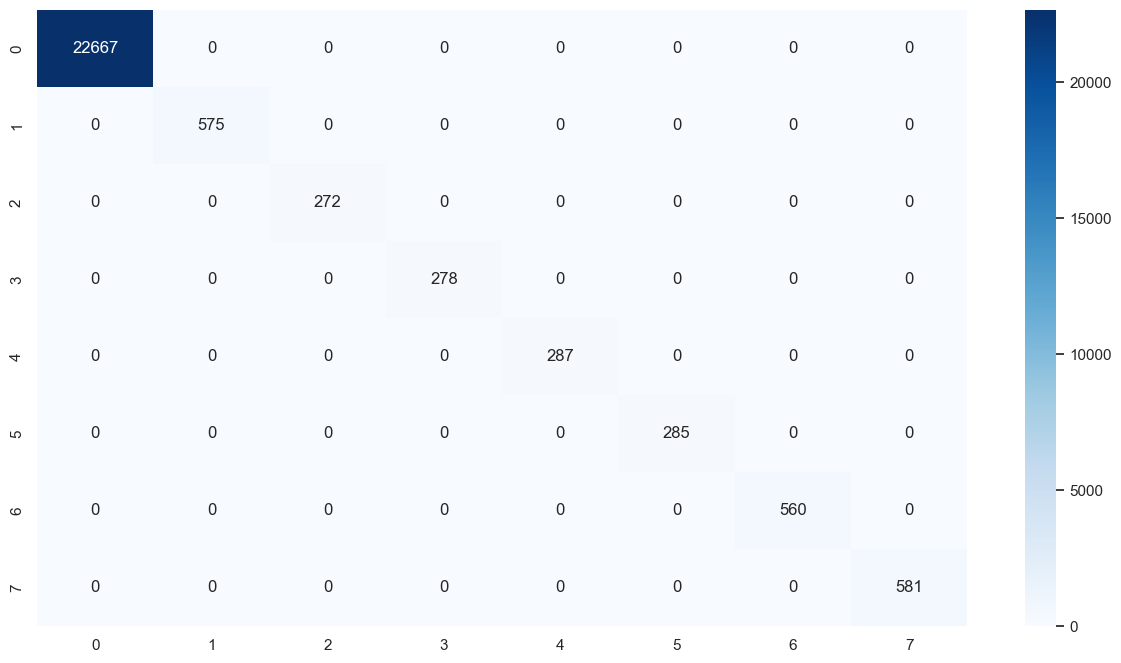

In [11]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})

predictions = clf.predict(X_test)

true_labels = y_test
clf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(clf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

# Test

In [12]:
# Read the valuation json, preprocess it and run the model 
with open(f'./datasets/dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)

# Preprocess the validation dataset
test_df['url_length'] = test_df.apply(lambda row: url_len(row), axis=1)
test_df["url_path_mid"] = test_df.apply(lambda row: url_path_mid(row), axis=1)
test_df["url_path_end"] = test_df.apply(lambda row: url_path_end(row), axis=1)
test_df["url_query"] = test_df.apply(lambda row: url_query(row), axis=1)
test_df["has_dollarsign"] = test_df.apply(lambda row: has_dollarsign(row), axis=1)
test_df["has_doubledot"] = test_df.apply(lambda row: has_double_dot(row), axis=1)
test_df["has_doubleUnderScore"] = test_df.apply(lambda row: has_double_underscore(row), axis=1)
test_df["has_sql_keyword"] = test_df.apply(lambda row: has_sql_keywords(row), axis=1)
test_df["has_forum"] = test_df.apply(lambda row: has_forum(row), axis=1)
test_df["has_new_line"] = test_df.apply(lambda row: has_new_line(row), axis=1)
for column in test_df.columns[test_df.isna().any()].tolist():
    test_df[column] = test_df[column].fillna('None')
test_df = vectorize_df(test_df)

# Predict with your model
X = test_df[features_list].to_numpy()
predictions = clf.predict(X)

# Save your predictions

In [13]:
# Save the preditions
enc = LabelEncoder()
np.savetxt(f'./datasets/dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')